<h1>Predictive Model for Restaurant Recommendation</h1>

<h2>1. Import Libraries and Load Data</h2>

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import re
import requests

<h2>2. Data Preprocessing</h2>

Load and Prepare Data

In [2]:
# Import Data
df = pd.read_csv('./data/portsmouth_restaurants_google_maps_data.csv')
df_location = pd.read_csv('./data/portsmouth_restaurants_location.csv')

# Sourced from and extracted from https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales
df_income_by_area = pd.read_csv('./data/income2020.csv')

# Sourced from https://open-geography-portalx-ons.hub.arcgis.com/datasets/ons::postcode-to-oa-2021-to-lsoa-to-msoa-to-lad-with-2011-classifications-november-2023-best-fit-lookup-in-the-uk/about
df_convert_to_post = pd.read_csv('./data/NSP21CL_NOV23_UK_LU.csv', encoding='latin-1')

C:\Users\JTOSH\AppData\Local\Temp\ipykernel_30388\3236429068.py:9: DtypeWarning: Columns (15,17,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_convert_to_post = pd.read_csv('./data/NSP21CL_NOV23_UK_LU.csv', encoding='latin-1')


In [ ]:
# Preprocess Data
# Clean price range
def parse_price_range(price):
    if type(price) == str:
      if 'moderate' == price.lower() or 'expensive' == price.lower():
        return np.nan      
      else:
        price = price.replace("£", "")
        bounds = price.split("–")
        return (float(bounds[0]) + float(bounds[1])) / 2 if len(bounds) == 2 else float(bounds[0])
    return np.nan

df['priceRangeAvg'] = df['priceRanges'].apply(parse_price_range)
df.fillna({'priceRangeAvg': df['priceRangeAvg'].median()}, inplace=True)

df.fillna({'phone': '000', 'web': 'no website', 'category': 'restaurant'}, inplace=True)

def remove_non_ascii(address):
    return re.sub(r'[^\x00-\x7F]+', '', address)

# Remove non ascii characters:
df['address'] = df['address'].apply(remove_non_ascii)
df['phone'] = df['phone'].apply(remove_non_ascii)
df['web'] = df['web'].apply(remove_non_ascii)

df.head(5)


In [ ]:
# df_location.info()
# df_location.describe()

print(f"The number of duplicate restaurants postcode is {df_location.duplicated(subset=['postcode']).sum()}")
df_location.drop_duplicates(subset=['postcode'], inplace=True)
print(f"The number of duplicate restaurants  postcode is {df_location.duplicated(subset=['postcode']).sum()}")
print(f"Missing values in each restaurant location column {df_location.isnull().sum()}")

df_location.drop(columns=['admin_county'], axis=1, inplace=True)

In [16]:
# Merge dataset
restaurants_df = df.merge(df_location, how='left', on='postcode' ) 
print(f"The number of rows in dataset is {restaurants_df.shape[0]}")
print(f"The number of columns in dataset is {restaurants_df.shape[1]}")
# restaurants_df.head()
# restaurants_df.info()

restaurants_df.dropna(subset=['latitude', 'longitude'], inplace=True)
restaurants_df.fillna(method='ffill', inplace=True)
restaurants_df.info()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(restaurants_df, geometry=gpd.points_from_xy(restaurants_df['longitude'], restaurants_df['latitude']))

The number of rows in dataset is 213
The number of columns in dataset is 18
<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 0 to 212
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            212 non-null    object 
 1   rating          212 non-null    float64
 2   ratingCount     212 non-null    float64
 3   priceRanges     212 non-null    object 
 4   category        212 non-null    object 
 5   address         212 non-null    object 
 6   postcode        212 non-null    object 
 7   openingHours    210 non-null    object 
 8   phone           212 non-null    object 
 9   web             212 non-null    object 
 10  serviceInfo     212 non-null    object 
 11  admin_county    212 non-null    object 
 12  admin_district  212 non-null    object 
 13  nuts            212 non-null    object 
 14  pfa             212 non-null    object 
 15  latitude        212 non-null    object 
 16  longitude

C:\Users\JTOSH\AppData\Local\Temp\ipykernel_30388\2212102449.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  restaurants_df.fillna(method='ffill', inplace=True)


Create average housing income by postcode by merging Portsmouth average house income by Middle Layer Super Output Area and postcode sample

In [ ]:
# # Filter for Portsmouth average house income by Middle Layer Super Output Area and postcode sample.
# df_income_by_area = df_income_by_area[df_income_by_area['Local authority name'] == 'Portsmouth']
# # df_income_by_area
# # df_convert_to_post = df_convert_to_post[['pcd8', 'msoa21cd', 'soac11nm', 'ladnm', 'laccd', 'lacnm']]

# msoa_df = df_income_by_area.merge(df_convert_to_post, how='left',  left_on='MSOA code', right_on='msoa21cd') 
# msoa_df.drop_duplicates(subset=['pcd8'], inplace=True)
# msoa_df.to_csv('./data/portsmouth_2020_housing_info.csv', index=False)

In [5]:
# Load the data
housing_info_df = pd.read_csv('./data/portsmouth_2020_housing_info.csv')

# # Extract postcodes
# housing_info_df_postcode = housing_info_df['pcd8'].dropna().tolist()

# # Define the base URL and endpoint
# BASE_URL = "https://api.postcodes.io"
# ENDPOINT = "/postcodes"

# def fetch_postcode_coordinates(postcodes):
#     """
#     Fetches latitude and longitude for a batch of postcodes using the API.
    
#     Args:
#         postcodes (list): List of postcodes in a batch.

#     Returns:
#         list: A list of dictionaries containing postcodes and their coordinates.
#     """
#     payload = {"postcodes": postcodes}
#     try:
#         response = requests.post(f"{BASE_URL}{ENDPOINT}", json=payload)
#         response.raise_for_status()
#         api_response = response.json()

#         if api_response["status"] == 200:
#             return [
#                 {
#                     "postcode": result["query"],
#                     "latitude": result["result"]["latitude"] if result["result"] else None,
#                     "longitude": result["result"]["longitude"] if result["result"] else None,
#                 }
#                 for result in api_response["result"]
#             ]
#         else:
#             print(f"API Error: {api_response['status']} - {api_response.get('error', {}).get('message', 'Unknown error')}")
#             return []
#     except requests.exceptions.RequestException as e:
#         print(f"Request failed: {e}")
#         return []

# def process_postcodes(postcodes, batch_size=99):
#     """
#     Processes postcodes in batches and retrieves coordinates for each.

#     Args:
#         postcodes (list): List of postcodes to process.
#         batch_size (int): Number of postcodes per batch.

#     Returns:
#         pd.DataFrame: DataFrame containing postcodes and their coordinates.
#     """
#     data = []
#     for i in range(0, len(postcodes), batch_size):
#         batch = postcodes[i:i + batch_size]
#         data.extend(fetch_postcode_coordinates(batch))
#     return pd.DataFrame(data)

# # Process postcodes and save the results
# postcode_data_df = process_postcodes(housing_info_df_postcode)
# postcode_data_df.to_csv("portsmouth_postcodes_with_coords.csv", index=False)

# print("CSV file created successfully!")


In [6]:
housing_postcode_geolocation = pd.read_csv("./data/portsmouth_postcodes_with_coords.csv")
housing_info_df = housing_info_df.merge(housing_postcode_geolocation, how='left',  left_on='pcd8', right_on='postcode') 

In [ ]:
print(housing_info_df.info())
print(f'The number of row before removing null values is {housing_info_df.shape[0]}')
housing_info_df.dropna(subset=['latitude', 'longitude'], how='any', inplace=True)
print(f'The number of row after removing null values is {housing_info_df.shape[0]}')
housing_info_df.to_csv("./data/portsmouth_postcodes_with_coords_sample.csv", index=False)


# def get_first_part_of_postcode(postcode):
#     return postcode.split(' ')[0]

# msoa_df.dropna(subset=['pcd8'], inplace=True)

# msoa_df['outward_code'] = msoa_df['pcd8'].apply(get_first_part_of_postcode)
# msoa_df.dropna(subset=['pcd8'], inplace=True)
# salary_postcode = msoa_df.groupby(['outward_code', 'Total annual income (�)']).size()
# salary_postcode                                                
# msoa_df.drop_duplicates(inplace=True)
# # msoa_df.info()
# msoa_df
# print(f'The number of rows is {msoa_df.shape[0]}')
# print(f'The number of columns is {msoa_df.shape[1]}')
# # Sourced from https://geoportal.statistics.gov.uk/datasets/e7824b1475604212a2325cd373946235/about
# df_convert_to_post = pd.read_csv('./data/NSP21CL_NOV23_UK_LU.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 3907 entries, 0 to 5077
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MSOA code                   3907 non-null   object 
 1   MSOA name                   3907 non-null   object 
 2   Local authority code        3907 non-null   object 
 3   Local authority name        3907 non-null   object 
 4   Region code                 3907 non-null   object 
 5   Region name                 3907 non-null   object 
 6   Total annual income (�)     3907 non-null   object 
 7   Upper confidence limit (�)  3907 non-null   object 
 8   Lower confidence limit (�)  3907 non-null   object 
 9   Confidence interval (�)     3907 non-null   object 
 10  pcd8                        3907 non-null   object 
 11  msoa21cd                    3907 non-null   object 
 12  soac11nm                    3907 non-null   object 
 13  ladnm                       3907 non-n

In [20]:
housing_info_df.columns

gdf.columns

Index(['name', 'rating', 'ratingCount', 'priceRanges', 'category', 'address',
       'postcode', 'openingHours', 'phone', 'web', 'serviceInfo',
       'admin_county', 'admin_district', 'nuts', 'pfa', 'latitude',
       'longitude', 'country', 'geometry', 'cluster'],
      dtype='object')

<h2>3. Geospatial Analysis</h2>

Compute Similarity Scores

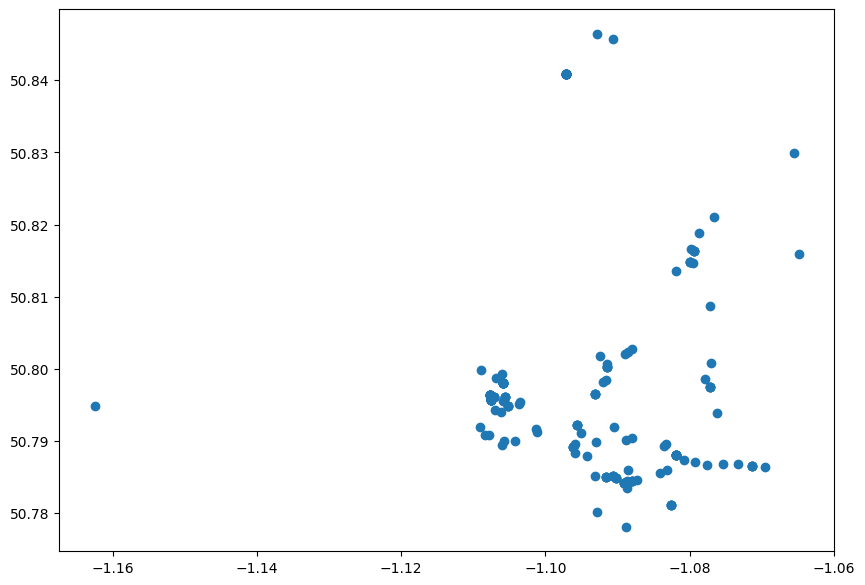

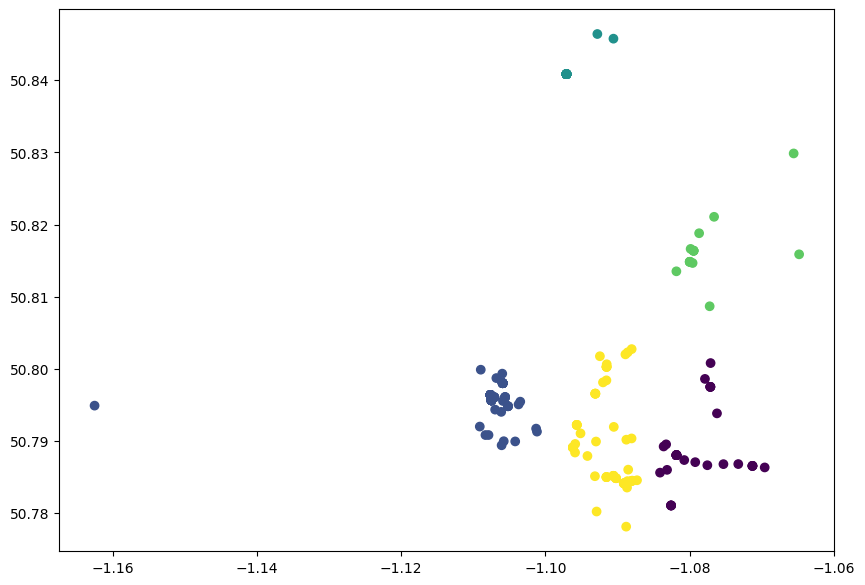

,name,rating,ratingCount,priceRanges,category,address,postcode,openingHours,phone,web,serviceInfo,admin_county,admin_district,nuts,pfa,latitude,longitude,country,geometry,cluster
0,Cocked Hat,4.0,2209.0,£10–20,Pub,"Privett Rd, Gosport PO12 3TR",PO12 3TR,NaN,023 9258 3422,greeneking.co.uk,"{""Accessibility"":""Wheelchair-accessible car pa...",Hampshire,Gosport,Gosport,Hampshire,50.794883,-1.162522,England,POINT (-1.16252 50.79488),1
1,Tap & Tandoor,4.7,579.0,£10–20,Gastropub,"Gunwharf Rd, Portsmouth PO1 3TJ",PO1 3TJ,NaN,023 9381 3150,tapandtandoor.co.uk,"{""Accessibility"":""Wheelchair-accessible car pa...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.794328,-1.106968,England,POINT (-1.10697 50.79433),1
2,Bella Calabria,4.4,919.0,£10–20,Italian restaurant,"45 London Rd, North End, Portsmouth PO2 0BH",PO2 0BH,"{""Sunday"":""12 - 10pm"",""Monday"":""12 - 10pm"",""Tu...",023 9269 4371,bellacalabriaportsmouth.com,"{""Accessibility"":""Wheelchair-accessible entran...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.814827,-1.079977,England,POINT (-1.07998 50.81483),3
3,Bella Calabria,4.4,919.0,£10–20,Italian restaurant,"45 London Rd, North End, Portsmouth PO2 0BH",PO2 0BH,"{""Sunday"":""12 - 10pm"",""Monday"":""12 - 10pm"",""Tu...",023 9269 4371,bellacalabriaportsmouth.com,"{""Accessibility"":""Wheelchair-accessible entran...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.814827,-1.079977,England,POINT (-1.07998 50.81483),3
4,Nice Tin Tin Chinese Restaurant,4.4,456.0,£10–20,Chinese restaurant,"28 The Hard, Portsmouth PO1 3DT",PO1 3DT,"{""Sunday"":""12 - 10:30pm"",""Monday"":""12 - 10:30p...",023 9217 4590,nicetintin.co.uk,"{""Accessibility"":""Wheelchair-accessible car pa...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.797996,-1.105920,England,POINT (-1.10592 50.798),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Sacred Chow - Portsmouth,5.0,2.0,£1–10,Vegetarian restaurant,"Osborne Rd, Southsea, Portsmouth, Southsea PO...",PO5 3LS,{},023 9279 7595,unclesams.co.uk,"{""Accessibility"":""Wheelchair-accessible entran...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.785146,-1.090560,England,POINT (-1.09056 50.78515),4
209,Sacred Chow - Portsmouth,5.0,2.0,£1–10,Vegetarian restaurant,"Osborne Rd, Southsea, Portsmouth, Southsea PO...",PO5 3LS,{},023 9279 7595,unclesams.co.uk,"{""Accessibility"":""Wheelchair-accessible entran...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.785146,-1.090560,England,POINT (-1.09056 50.78515),4
210,Nemrut Restaurant (Southsea),4.6,410.0,£20–30,Turkish restaurant,"94 Albert Rd, Southsea, Portsmouth, Southsea ...",PO5 2SN,"{""Sunday"":""3:30 - 11pm"",""Monday"":""3:30 - 11pm""...",023 9275 6777,nemrutturkishrestaurant.com,"{""Accessibility"":""Wheelchair-accessible entran...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.786617,-1.077537,England,POINT (-1.07754 50.78662),0
211,Sopranos,4.6,545.0,£20–30,Italian restaurant,"108 Palmerston Rd, Southsea, Portsmouth, Sout...",PO5 3PT,"{""Sunday"":""Closed"",""Monday"":""Closed"",""Tuesday""...",023 9281 1139,sopranos-southsea.com,"{""Accessibility"":""Wheelchair-accessible entran...",Hampshire,Portsmouth,Portsmouth,Hampshire,50.784109,-1.089119,England,POINT (-1.08912 50.78411),4


In [18]:
# Visualize the restaurant locations on a map
gdf.plot(figsize=(10, 8))
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(gdf[['longitude', 'latitude']])
gdf['cluster'] = kmeans.labels_

# Visualize the clusters
gdf.plot(column='cluster', cmap='viridis', figsize=(10, 8))
plt.show()

gdf

In [45]:
customer_gdf = gpd.GeoDataFrame(housing_info_df, geometry=gpd.points_from_xy(housing_info_df['longitude'], housing_info_df['latitude']))
restaurant_gdf = gpd.GeoDataFrame(restaurants_df, geometry=gpd.points_from_xy(restaurants_df['longitude'], restaurants_df['latitude']))

print(customer_gdf.shape[0])
print(restaurant_gdf.shape[0])
# # Spatial Join
# spatial_join = gpd.sjoin(customer_gdf, restaurant_gdf, how="left", op='intersects')

# # Feature Engineering
# spatial_join['restaurant_density'] = spatial_join.groupby('MSOA code')['geometry'].transform('count')
# spatial_join['avg_restaurant_rating'] = spatial_join.groupby('MSOA code')

# spatial_join

def spatial_join(left_gdf, right_gdf):
    joined_gdf = gpd.sjoin_nearest(left_gdf, right_gdf, how='inner', max_distance=0.9)
    return joined_gdf

spatial_join = spatial_join(restaurant_gdf, customer_gdf)

spatial_join.to_csv("./data/spatial_data.csv", index=False)

# spatial_join.info()

# spatial_join.columns

# # Use a classification model to identify target areas
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# X = spatial_join[['Total annual income (�)']]
# y = spatial_join['target_area']  # A binary label indicating whether an area is a target or not

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train, y_train)   


# y_pred = rf.predict(X_test)

# # Evaluate the model
# from sklearn.metrics import accuracy_score, classification_report

# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred)) 


3907
212


In [55]:
from collections import defaultdict

spatial_join = pd.read_csv("./data/spatial_data.csv")

restuarant_catgory = spatial_join['category'].unique()


# Assuming 'MSOA code' is the unique identifier for MSOA
restaurant_density = defaultdict(int)
for index, row in spatial_join.iterrows():
    msoa_code = row['MSOA code']
    if row['category'] in restuarant_catgory:  # Adjust categories as needed
        restaurant_density[msoa_code] += 1

# Add 'restaurant_density' as a new column in the DataFrame
spatial_join['restaurant_density'] = spatial_join['MSOA code'].apply(lambda x: restaurant_density[x])

average_rating = defaultdict(float)
restaurant_count = defaultdict(int)
for index, row in spatial_join.iterrows():
    msoa_code = row['MSOA code']
    if row['category'] in restuarant_catgory:  
        average_rating[msoa_code] += row['rating']
        restaurant_count[msoa_code] += 1

# Add 'average_rating' as a new column in the DataFrame (handle division by zero)
spatial_join['average_rating'] = spatial_join['MSOA code'].apply(lambda x: average_rating[x] / (restaurant_count[x] or 1))
spatial_join.to_csv("./data/spatial_data_addtion.csv")

In [56]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Load the data
customer_data = pd.read_csv('./data/portsmouth_2020_housing_info.csv')
restaurant = pd.read_csv('./data/portsmouth_restaurants_google_maps_data.csv')
restaurant_location = pd.read_csv('./data/portsmouth_restaurants_location.csv')
restaurant_data = restaurant.merge(restaurant_location, how="left", on="postcode")

# Geocode MSOA codes to latitude and longitude
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)

def geocode_msoa(msoa_code):
    """
    Geocode MSOA code to latitude and longitude using Nominatim.
    
    Args:
        msoa_code (str): MSOA code to geocode.
    
    Returns:
        tuple: Latitude and longitude if found; otherwise (None, None).
    """
    try:
        location = geolocator.geocode(msoa_code)
        if location:
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        pass
    return None, None

# Apply geocoding with caching for improved efficiency
print("Geocoding MSOA codes...")
customer_data['latitude'], customer_data['longitude'] = zip(*customer_data['MSOA code'].map(geocode_msoa))

# Drop rows with missing coordinates
customer_data = customer_data.dropna(subset=['latitude', 'longitude'])

print("Customer data...")
customer_data.to_csv("./data/customer_data.csv")

# Create GeoDataFrames
customer_gdf = gpd.GeoDataFrame(
    customer_data, geometry=gpd.points_from_xy(customer_data['longitude'], customer_data['latitude']), crs="EPSG:4326"
)
restaurant_gdf = gpd.GeoDataFrame(
    restaurant_data, geometry=gpd.points_from_xy(restaurant_data['longitude'], restaurant_data['latitude']), crs="EPSG:4326"
)

# Perform Spatial Join
print("Performing spatial join...")
spatial_join = gpd.sjoin(customer_gdf, restaurant_gdf, how="left", predicate='intersects')

# Feature Engineering
print("Engineering features...")
spatial_join['restaurant_density'] = spatial_join.groupby('MSOA code')['geometry'].transform('count')
spatial_join['avg_restaurant_rating'] = spatial_join.groupby('MSOA code')['rating'].transform('mean')

# Handle missing values
spatial_join['restaurant_density'] = spatial_join['restaurant_density'].fillna(0)
spatial_join['avg_restaurant_rating'] = spatial_join['avg_restaurant_rating'].fillna(spatial_join['avg_restaurant_rating'].mean())

# Prepare data for modeling
features = ['restaurant_density', 'avg_restaurant_rating', 'Total annual income']
spatial_join = spatial_join.dropna(subset=features)  # Ensure no missing values in features
X = spatial_join[features]
y = spatial_join['target_area']  # Assuming target area labels exist

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
print("Training the model...")
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Model Evaluation:")
print(classification_report(y_test, y_pred))

# Save the processed data for downstream tasks
spatial_join.to_csv("processed_spatial_data.csv", index=False)
print("Processed data saved to 'processed_spatial_data.csv'.")


Geocoding MSOA codes...


KeyboardInterrupt: 

In [4]:
test = """```Install required libraries
!pip install -q pyexcel-xlsx
!pip install -q pandas
import pandas as pd
from pyexcel_xlsx import get_data
# Read data from Excel file
df = pd.read_excel('stock_data.xlsx')
# Filter data for TSLA and NVDA
tsla = df[df['Symbol'] == 'TSLA']
nvda = df[df['Symbol'] == 'NVDA']
# Calculate performance metrics for TSLA and NVDA
tsla_performance = tsla.iloc[:, 5:].sum(axis=1) / tsla.iloc[:, 6:].mean()
nvda_performance = nvda.iloc[:, 5:].sum(axis=1) / nvda.iloc[:, 6:].mean()
# Create a dataframe with the performance metrics for both stocks
results = pd.DataFrame({'TSLA': tsla_performance, 'NVDA': nvda_performance})
# Save results to a PowerPoint presentation
results.to_excel('analysis.xlsx', index=False)
This code generates a chart comparing the performance of TSLA and NVDA stocks using data from an Excel file called "stock_data.xlsx". The chart is saved as a new Excel file called "analysis.xlsx```"""
print(test)



```Install required libraries
!pip install -q pyexcel-xlsx
!pip install -q pandas
import pandas as pd
from pyexcel_xlsx import get_data
# Read data from Excel file
df = pd.read_excel('stock_data.xlsx')
# Filter data for TSLA and NVDA
tsla = df[df['Symbol'] == 'TSLA']
nvda = df[df['Symbol'] == 'NVDA']
# Calculate performance metrics for TSLA and NVDA
tsla_performance = tsla.iloc[:, 5:].sum(axis=1) / tsla.iloc[:, 6:].mean()
nvda_performance = nvda.iloc[:, 5:].sum(axis=1) / nvda.iloc[:, 6:].mean()
# Create a dataframe with the performance metrics for both stocks
results = pd.DataFrame({'TSLA': tsla_performance, 'NVDA': nvda_performance})
# Save results to a PowerPoint presentation
results.to_excel('analysis.xlsx', index=False)
This code generates a chart comparing the performance of TSLA and NVDA stocks using data from an Excel file called "stock_data.xlsx". The chart is saved as a new Excel file called "analysis.xlsx```
